## Projeção Perspectiva

In [1]:
from pathlib import Path
from skimage import io, transform
import numpy as np
from numpy.linalg import solve
from matplotlib import pyplot as plt

In [2]:
def warp_naive(
    image: np.ndarray, gmt: np.ndarray, inverse: bool = False
) -> np.ndarray:
    """Apply a geometric transformation to an image.

    Parameters:
        image: input image
        gmt: transformation matrix (3x3)
        inverse: if True, apply the inverse transformation
    Returns:
        t_image: transformed image
    """

    t_image = np.zeros_like(image)

    # (x_i, y_i, w) = transform * (x_o, y_o, 1)
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            # Get the coordinates of the transformed pixel
            coords = gmt @ np.array([x, y, 1])

            # Normalize the coordinates (x, y, w) -> (x/w, y/w, 1)
            x_t, y_t, _ = coords / coords[2]

            # Check if the pixel is inside the image
            inside = (
                (x_t >= 0)
                & (y_t >= 0)
                & (x_t < image.shape[1])
                & (y_t < image.shape[0])
            )
            if not inside:
                continue

            # Get the pixel value
            # print(int(round(x_t)), int(round(y_t)))
            if inverse:
                t_image[y, x] = image[int(y_t), int(x_t)]
            else:
                t_image[int(y_t), int(x_t)] = image[y, x]

    return t_image


def warp_vet(
    image: np.ndarray, gmt: np.ndarray, inverse: bool = False
) -> np.ndarray:
    """Apply a geometric transformation to an image.
    (Vectorized version)
    Parameters:
        image: input image
        gmt: transformation matrix (3x3)
        inverse: if True, apply the inverse transformation
    Returns:
        t_image: transformed image
    """

    # Get the coordinates of the pixels
    rows, cols = image.shape
    indeces = np.indices((rows, cols))
    # coord = (x, y, 1)
    coords = np.vstack(
        (
            indeces[1].ravel(),
            indeces[0].ravel(),
            np.ones(rows * cols, dtype=np.int32),
        )
    )

    # Apply the transformation
    t_coords = gmt @ coords
    t_coords = np.round(t_coords[:2] / t_coords[2]).astype(np.int32)

    # Create the transformed image
    t_image = np.zeros_like(image)
    # Check if the pixel is inside the image
    inside = (
        (t_coords[0] >= 0)
        & (t_coords[1] >= 0)
        & (t_coords[0] < cols)
        & (t_coords[1] < rows)
    )
    if inverse:
        t_image[coords[1][inside], coords[0][inside]] = image[
            t_coords[1][inside], t_coords[0][inside]
        ]
    else:
        t_image[t_coords[1][inside], t_coords[0][inside]] = image[
            coords[1][inside], coords[0][inside]
        ]

    return t_image

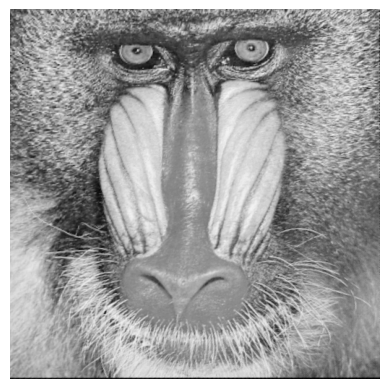

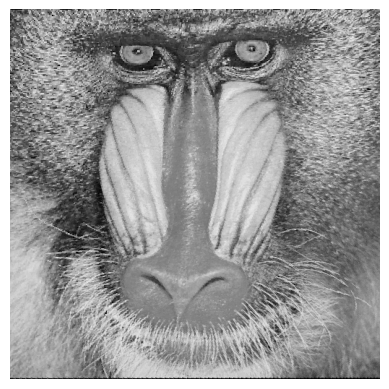

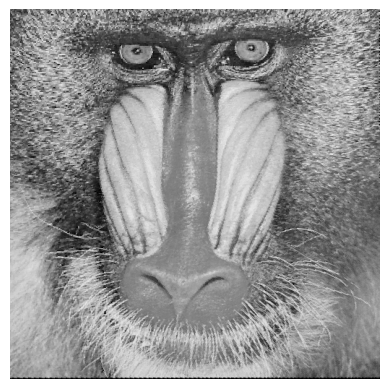

In [3]:
# Path to the images
images_path = Path('images')

# Read the images
image = io.imread(images_path / 'baboon_perspectiva.png')
image = image[:, :, 0]

# Define os pontos de origem e destino
src = np.array([[0, 0], [511, 0], [511, 511], [0, 511]])
dst = np.array([[37, 51], [342, 42], [485, 467], [73, 380]])

# Cria a matriz de coeficientes do sistema de equações
A = np.zeros((8, 8))
for i in range(4):
    A[i * 2, :] = [
        src[i, 0],
        src[i, 1],
        1,
        0,
        0,
        0,
        -dst[i, 0] * src[i, 0],
        -dst[i, 0] * src[i, 1],
    ]
    A[i * 2 + 1, :] = [
        0,
        0,
        0,
        src[i, 0],
        src[i, 1],
        1,
        -dst[i, 1] * src[i, 0],
        -dst[i, 1] * src[i, 1],
    ]

# Cria o vetor de soluções do sistema de equações
b = np.zeros((8,))
for i in range(4):
    b[i * 2] = dst[i, 0]
    b[i * 2 + 1] = dst[i, 1]

# Resolve o sistema de equações
h = solve(A, b)

# Cria a matriz de projeção perspectiva
H = np.zeros((3, 3))
H[0, :] = h[:3]
H[1, :] = h[3:6]
H[2, :2] = h[6:]
H[2, 2] = 1

# Aplicar a transformação perspectiva usando a função do skimage
tform = transform.ProjectiveTransform()
tform.estimate(src, dst)
image_transformed_1 = transform.warp(image, tform)

# Mostrar as imagens
plt.imshow(image_transformed_1, cmap='gray')
plt.axis('off')
plt.show()

image_transformed_2 = warp_naive(image, H, inverse=True)
plt.imshow(image_transformed_2, cmap='gray')
plt.axis('off')
plt.show()

image_transformed_3 = warp_vet(image, H, inverse=True)
plt.imshow(image_transformed_3, cmap='gray')
plt.axis('off')
plt.show()

## 2 Transformações Geométricas

### Bibliotecas

In [73]:
from pathlib import Path
import numpy as np
from skimage import transform, io
from matplotlib import pyplot as plt

### Funções Auxiliares

In [74]:
def open_image(image_path: Path) -> np.ndarray:
    """Abre uma imagem binária e retorna uma matriz numpy.
    Parâmetros:
        image_path: caminho para a imagem
    Retorno:
        Imagem como uma matriz numpy.
    """
    image = io.imread(image_path)
    assert (
        len(image.shape) == 2
    ), f'A Imagem {image_path.name} tem mais de 1 canal'
    # returns a binary version of the image
    return image


def two_images(
    original: np.ndarray,
    processed: np.ndarray,
    t1: str,
    t2: str,
    path: Path = None,
):
    """Visualizar a imagem original versus o resultado do processamento.
    Parâmetros:
        original: imagem original
        processed: imagem processada
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
    fig.tight_layout(pad=0.5)

    axs[0].imshow(original, cmap='gray')
    axs[1].imshow(processed, cmap='gray')

    axs[0].set_title(f'(a) {t1}')
    axs[1].set_title(f'(b) {t2}')

    axs[0].axis('off')
    axs[1].axis('off')
    plt.show()

    if path:
        fig.savefig(path, bbox_inches='tight', pad_inches=0.1)


def histogram(img: np.ndarray, bins: int = 256) -> np.ndarray:
    """Calcula o histograma de uma imagem.
    Parâmetros:
        img: imagem
        bins: número de bins
    """
    return np.histogram(img, bins=bins)[0]


def black_percentual(histogram: np.ndarray) -> float:
    """Calcula o percentual de pixels pretos em uma imagem.
    Parâmetros:
        histogram: histograma da imagem
    Retorno:
        Percentual de pixels pretos.
    """
    return np.round(histogram[0] / histogram.sum(), 4) * 100


def img_and_histogram(
    img: np.ndarray, hist: np.ndarray, title: str, path: Path = None
):
    """Visualizar a imagem e seu histograma.
    Parâmetros:
        img: imagem
        hist: histograma
    """
    fig, axs = plt.subplots(
        nrows=1, ncols=2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]}
    )
    plt.suptitle(title)

    # Image
    axs[0].set_title('(a) Imagem')
    axs[0].imshow(img, cmap='gray')
    axs[0].axis('off')

    # Histogram
    axs[1].set_title('(b) Histograma')
    bins_range = range(hist.shape[0])
    if hist.shape[0] == 2:
        percents = [black_percentual(hist), 100 - black_percentual(hist)]
        bar = axs[1].bar(
            bins_range,
            percents,
            width=1,
            align='center',
            edgecolor='black',
            color='#006AF4',
        )
        axs[1].set_xticks([0, 1], ['preto', 'branco'])
        axs[1].axes.yaxis.set_visible(False)
        axs[1].spines['right'].set_visible(False)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        black_per = f'{percents[0]:.2f}%'
        axs[1].text(
            bar[0].get_x() + bar[0].get_width() / 2,
            bar[0].get_height(),
            black_per,
            ha='center',
            va='bottom',
            fontsize=12,
        )
        white_per = f'{percents[1]:.2f}%'
        axs[1].text(
            bar[1].get_x() + bar[1].get_width() / 2,
            bar[1].get_height(),
            white_per,
            ha='center',
            va='bottom',
            fontsize=12,
        )
    else:
        axs[1].bar(bins_range, hist, color='#006AF4')
        text = f'preto: {black_percentual(hist):.2f}%'
        axs[1].text(
            0.2,
            0.9,
            text,
            transform=axs[1].transAxes,
            color='black',
            fontsize=14,
        )

    plt.show()

    # Save figure
    if path:
        fig.savefig(path, bbox_inches='tight', pad_inches=0.1)


def image_properties(image: np.ndarray):
    """Imprime as propriedades da imagem.
    Parâmetros:
        image: imagem
    """
    print('Propriedades da imagem:')
    print(f'Dimensões: {image.shape}')
    print(f'Tipo de dados: {image.dtype}')
    print(f'Mínimo: {image.min()}')
    print(f'Máximo: {image.max()}')

### Abrir a imagem original

In [75]:
images_path = Path('images')
image = open_image(images_path / 'baboon.png')
image_properties(image)

Propriedades da imagem:
Dimensões: (512, 512)
Tipo de dados: uint8
Mínimo: 0
Máximo: 230


### Transformações Geométricas

#### Rotação

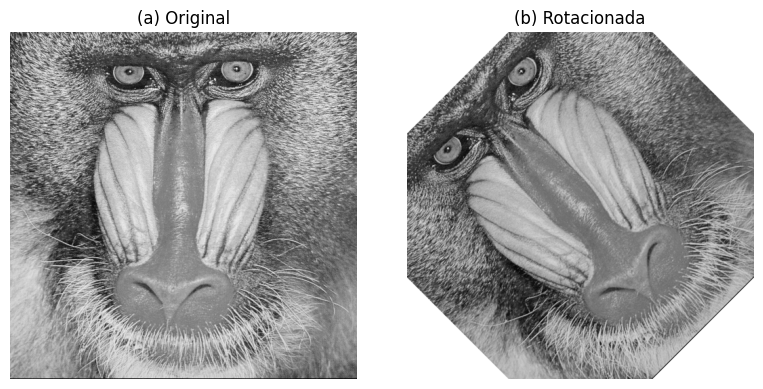

Propriedades da imagem:
Dimensões: (512, 512)
Tipo de dados: float64
Mínimo: 0.013605210779915253
Máximo: 1.0


In [76]:
# Definir angulo de rotação
angle = 45
# Definir o centro de rotação
center = (0, 0)
center = None
mode = ['constant', 'edge', 'symmetric', 'reflect', 'wrap']
# Rotacionar a imagem
image_rotated = transform.rotate(
    image, angle, resize=False, center=center, order=3, mode='constant', cval=1
)

# Visualizar a imagem original e a rotacionada
two_images(image, image_rotated, 'Original', 'Rotacionada')

# propriedades da imagem rotacionada
image_properties(image_rotated)

#### Escala (Fator de escala)

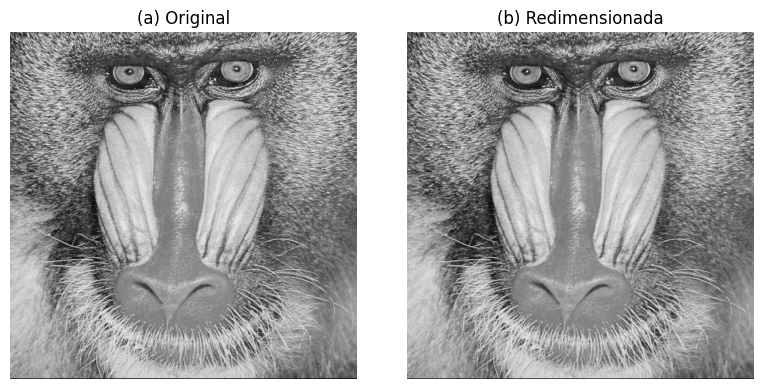

Propriedades da imagem:
Dimensões: (1024, 1024)
Tipo de dados: float64
Mínimo: 0.0
Máximo: 0.9019607843137255


In [78]:
# Definir o fator de escala
scale = 2

# Redimensionar a imagem
image_resized = transform.rescale(
    image, scale, order=3, anti_aliasing=False, mode='constant', cval=1
)

# Visualizar a imagem original e a redimensionada
two_images(image, image_resized, 'Original', 'Redimensionada')

# propriedades da imagem redimensionada
image_properties(image_resized)

#### Escala (Altura, Largura)

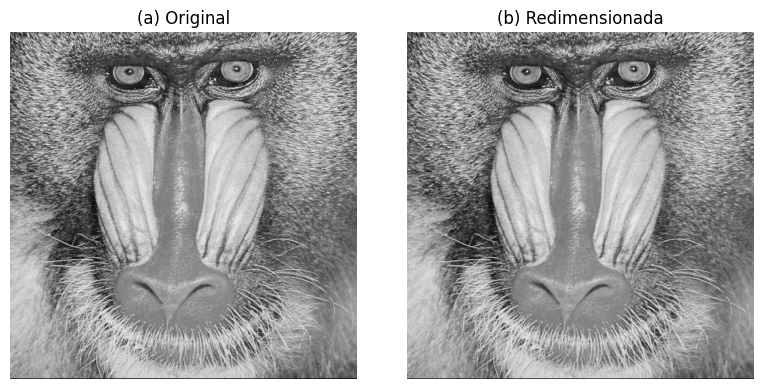

Propriedades da imagem:
Dimensões: (1024, 1024)
Tipo de dados: float64
Mínimo: 0.0
Máximo: 0.9019607843137255


In [84]:
# Definir altura e largura
height, width = 1024, 1024

# Redimensionar a imagem
image_resized = transform.resize(
    image,
    (height, width),
    order=3,
    anti_aliasing=False,
    mode='constant',
    cval=1,
)

# Visualizar a imagem original e a redimensionada
two_images(image, image_resized, 'Original', 'Redimensionada')

# propriedades da imagem redimensionada
image_properties(image_resized)